# Object recognition for The Image Bank of Tartu

Using transfer learning, `ResNet34`
Not really getting the desired accuracy, maybe dataset is too small.

**Author: Amos Fang**

## 1. Load Data (Train and Test)

In [1]:
import pandas as pd

# Read the train.csv to df and perform one-hot encoding on the image labels
df = pd.read_csv('train.csv')
one_hot_df = df['labels'].str.get_dummies(sep=' ')
df = pd.concat([df, one_hot_df], axis=1)

# Read the labels.csv and rename the column features as feature names
label = pd.read_csv('labels.csv')
df = df.rename(columns=dict(label.values))

# Display first 5 entries
df.head()

,image_id,labels,people,trees,nature,bicycle,pavement,flowers,traffic signs,lamp posts,...,table,pencil,stroller,tents,stage,book,books,cars,flag,pole
0,img256.jpg,l16 l18 l23 l25 l73,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,img98.jpg,l0 l24 l26 l39,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,img147.jpg,l14 l3,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,img254.jpg,l2 l25 l29,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,img160.jpg,l0 l32 l38 l40 l6,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2]:
# Read the train.csv to test_df and add same columns as df
test_df = pd.read_csv('test.csv')
test_df['labels'] = ''

test_df.head()

,image_id,labels
0,img102.jpg,
1,img103.jpg,
2,img11.jpg,
3,img113.jpg,
4,img114.jpg,


## 2. Resize images and save them to train and test folders

In [3]:
import os
from PIL import Image

# Set default_folder as global variable
default_folder = "images/"

# Images are resized to default 256 by 256 pixels before data_loaders transform
size = (256, 256)

def resize_image(df, image_pathname=default_folder, folder_type="train/"):
    """
    Saves the resized image to the train or test folder

    :param df: train or test df
    :param image_pathname: the default folder where all the images are stored
    :param folder_type: either the train or test folder is created within the images folder
    """
    folder_pathname = os.path.join(image_pathname, folder_type)
    
    # Create train / test folder if not available
    if not os.path.exists(folder_pathname):
        os.mkdir(folder_pathname)
        
    folder_pathname = image_pathname + folder_type
    
    # Resize and save image to train or test folder within the original images folder
    for image_filename in df['image_id']:
        image_path = os.path.join(image_pathname, image_filename)
        if os.path.exists(image_path):
            image = Image.open(image_path)
            # Resize the image
            image = image.resize(size)
            # Save the resized image to the train or test folder
            image.save(os.path.join(folder_pathname, image_filename))

resize_image(df, default_folder, "train/")
resize_image(test_df, default_folder, "test/")

In [4]:
# There are image_ids in train.csv missing in the images folder

df['Exists'] = df['image_id'].apply(lambda image: True if os.path.exists('images/train/'+image) else False)
test_df['Exists'] = test_df['image_id'].apply(lambda image: True 
                                              if os.path.exists('images/test/'+image) else False)

# Exclude these images, as there is nothing we can do about them
df = df[df['Exists']].iloc[:,:-1].reset_index(drop=True)
test_df = test_df[test_df['Exists']].iloc[:,:-1].reset_index(drop=True)

In [5]:
df.shape

(201, 94)

In [6]:
test_df

,image_id,labels
0,img102.jpg,
1,img103.jpg,
2,img11.jpg,
3,img113.jpg,
4,img114.jpg,
...,...,...
81,img81.jpg,
82,img84.jpg,
83,img90.jpg,
84,img93.jpg,


## 3. Image Transform

In [7]:
batch_size = 16  # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2  # fraction of the training data to reserve for validation
num_epochs = 300  # number of epochs for training
num_classes = 92 # number of classes. Do not change this
learning_rate = 0.002  # Learning rate for SGD (or Adam)
opt = 'sgd'      # optimizer. 'sgd' or 'adam'
weight_decay = 0.0 # regularization. Increase this to combat overfitting
num_workers = 2

Data Transform functions

In [8]:
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, SubsetRandomSampler, DataLoader
import torch
import numpy as np
from math import ceil

image_folder = "images/train"

def compute_mean_and_std():
    # Create a list of image filenames in a folder
    image_filenames = os.listdir(image_folder)

    # Initialize lists to store the pixel values of each image
    images = []
    for image_filename in image_filenames:
        image_path = os.path.join(image_folder, image_filename)
        image = Image.open(image_path)
        
        # Convert the image to a numpy array
        image_array = np.asarray(image)
        images.append(image_array)

    # Convert the list of image arrays to a numpy array with shape (num_images, height, width, channels)
    images_array = np.stack(images, axis=0)

    # Compute the mean and standard deviation of the images
    mean = np.mean(images_array, axis=(0,1,2))
    std = np.std(images_array, axis=(0,1,2))

    return mean, std

# Compute mean and std of the dataset
mean, std = compute_mean_and_std()
print(f"Dataset mean: {mean}, std: {std}")

data_transforms = {
    "train": transforms.Compose([
#         transforms.Resize((256,256)), # Resize the image to 256x256 pixels
        transforms.RandomCrop(224), # Randomly crop the image to 224x224 pixels
        # Augmentation
        transforms.RandomHorizontalFlip(p=0.5), 
        transforms.RandomRotation(10),
        transforms.RandomChoice([
                transforms.ColorJitter(hue=0.3),
                transforms.ColorJitter(brightness=0.2),
                transforms.ColorJitter(saturation=0.2),
                transforms.ColorJitter(contrast=1.2),
            ]),
        transforms.ToTensor(), # Convert the image to a Pytorch tensor
        transforms.Normalize(mean=mean, std=std)  # Normalize the image
    ]),
    "valid": transforms.Compose([
#         transforms.Resize((256,256)), # Resize the image to 256x256 pixels
        transforms.CenterCrop(224), # Center crop the image to 224x224 pixels
        # Augmentation
        transforms.RandomHorizontalFlip(p=0.5), 
        transforms.RandomRotation(10),
        transforms.RandomChoice([
                transforms.ColorJitter(hue=0.3),
                transforms.ColorJitter(brightness=0.2),
                transforms.ColorJitter(saturation=0.2),
                transforms.ColorJitter(contrast=1.2),
            ]),
        transforms.ToTensor(), # Convert the image to a Pytorch tensor
        transforms.Normalize(mean=mean, std=std)  # Normalize the image
    ]),
    "test": transforms.Compose([
#         transforms.Resize((256,256)), # Resize the image to 256x256 pixels
        transforms.CenterCrop(224), # Center crop the image to 224x224 pixels
        transforms.ToTensor(), # Convert the image to a Pytorch tensor
        transforms.Normalize(mean=mean, std=std)  # Normalize the image
    ]),
}

Dataset mean: [131.7414109  127.09499371 116.48642378], std: [68.19535941 66.92339383 72.32523952]


Transform the images to a `torch.tensor`

In [9]:
def transform_image(df, image_folder=default_folder, transform_type='train'):
    transform_data = []
    for image_filename in df['image_id']:
        image_path = os.path.join(image_folder + transform_type + "/", image_filename)
        if os.path.exists(image_path):
            image = Image.open(image_path)
            # Resize the image
            transformed_image = data_transforms[transform_type](image)
            # Save the resized image to a new file
            transform_data.append(transformed_image)
    return torch.stack(transform_data)

# Transform images in the train and test folder
train_dataset = transform_image(df)
test_dataset = transform_image(test_df, default_folder, 'test')

In [10]:
train_dataset.shape

torch.Size([201, 3, 224, 224])

In [11]:
# Convert pandas dataframe to numpy to torch tensor
train_labels = torch.tensor(df.iloc[:,2:].values)

# Label the train dataset
train_dataset = TensorDataset(train_dataset, train_labels.float())

# Convert test_dataset to a TensorDataSet
test_dataset = TensorDataset(test_dataset)

Launch the Dataloader for train, valid and test

In [12]:
# Obtain training indices that will be used for validation
n_tot = df.shape[0]
indices = torch.randperm(n_tot)

split = int(ceil(valid_size * n_tot))
train_idx, valid_idx = indices[split:], indices[:split]

# Define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx) 

# Prepare data loaders
data_loaders = {"train": "images/train", "valid": "images/train", "test": "images/test"}

data_loaders['train'] = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=train_sampler,
    num_workers=num_workers,
)
data_loaders['valid'] = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=valid_sampler,
    num_workers=num_workers,
)
data_loaders["test"] = DataLoader(
    # Add shuffle=False as well)
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [13]:
data_loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fdc56bcf2e0>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x7fdc56bcf100>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fdc56bcf370>}

## 4. Train the model

In [14]:
from torchvision.models import resnet34
import torch.nn as nn

# Get a model using get_model_transfer_learning. Use one of the names reported here:
# https://pytorch.org/vision/0.10/models.html
# For example, if you want to load ResNet 18, use "resnet18"
# NOTE: use the hyperparameters defined in the previous cell, do NOT copy/paste the
# values
model = resnet34(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

n_classes = num_classes
num_ftrs  = model.fc.in_features
model.fc  = nn.Linear(num_ftrs, n_classes) 


In [15]:
def get_optimizer(
    model: nn.Module,
    optimizer: str = "SGD",
    learning_rate: float = 0.01,
    momentum: float = 0.5,
    weight_decay: float = 0,
):
    """
    Returns an optimizer instance

    :param model: the model to optimize
    :param optimizer: one of 'SGD' or 'Adam'
    :param learning_rate: the learning rate
    :param momentum: the momentum (if the optimizer uses it)
    :param weight_decay: regularization coefficient
    """
    if optimizer.lower() == "sgd":
        # Create an instance of the SGD
        # optimizer. Use the input parameters learning_rate, momentum
        # and weight_decay
        opt = torch.optim.SGD(
            model.parameters(),
            lr=learning_rate,
            momentum=momentum,
            weight_decay=weight_decay           
        )

    elif optimizer.lower() == "adam":
        # Create an instance of the Adam
        # optimizer. Use the input parameters learning_rate, momentum
        # and weight_decay
        opt = torch.optim.Adam(
            model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        )
    else:
        raise ValueError(f"Optimizer {optimizer} not supported")

    return opt

def get_loss():
    """
    Get an instance of the MultiLabelSoftMarginLoss (useful for classification),
    optionally moving it to the GPU if use_cuda is set to True
    """

    loss = nn.MultiLabelSoftMarginLoss()

    return loss

In [16]:
import torch

from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot
from tqdm import tqdm
import matplotlib.pyplot as plt

def after_subplot(ax: plt.Axes, group_name: str, x_label: str):
    """Add title xlabel and legend to single chart"""
    ax.set_title(group_name)
    ax.set_xlabel(x_label)
    ax.legend(loc="center right")

    if group_name.lower() == "loss":
        ax.set_ylim([None, .5])

def train_one_epoch(train_dataloader, model, optimizer, loss):
    """
    Performs one train_one_epoch epoch
    """

    if torch.cuda.is_available():
        # Transfer the model to the GPU
        # HINT: use .cuda()
        model.cuda()
        # check this line of code

    # Set the model to training mode
    model.train()
    
    train_loss = 0.0

    for batch_idx, (data, target) in tqdm(
        enumerate(train_dataloader),
        desc="Training",
        total=len(train_dataloader),
        leave=True,
        ncols=80,
    ):
        # move data to GPU
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        # 1. clear the gradients of all optimized variables
        # 2. forward pass: compute predicted outputs by passing inputs to the model
        output  = model(data)
        # 3. calculate the loss
        loss_value  = loss(output, target)
        # 4. backward pass: compute gradient of the loss with respect to model parameters
        optimizer.zero_grad()
        # 5. perform a single optimization step (parameter update)
        loss_value.backward()
        optimizer.step()

        # update average training loss
        train_loss = train_loss + (
            (1 / (batch_idx + 1)) * (loss_value.data.item() - train_loss)
        )

    return train_loss

def valid_one_epoch(valid_dataloader, model, loss):
    """
    Validate at the end of one epoch
    """

    with torch.no_grad():

        # set the model to evaluation mode
        model.eval()

        if torch.cuda.is_available():
            model.cuda()

        valid_loss = 0.0
        for batch_idx, (data, target) in tqdm(
            enumerate(valid_dataloader),
            desc="Validating",
            total=len(valid_dataloader),
            leave=True,
            ncols=80,
        ):
            # move data to GPU
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            # 1. forward pass: compute predicted outputs by passing inputs to the model
            output  = model(data)
            # 2. calculate the loss
            loss_value  = loss(output, target)

            # Calculate average validation loss
            valid_loss = valid_loss + (
                (1 / (batch_idx + 1)) * (loss_value.data.item() - valid_loss)
            )

    return valid_loss

def optimize(data_loaders, model, optimizer, loss, n_epochs, save_path, interactive_tracking=False):
    # initialize tracker for minimum validation loss
    if interactive_tracking:
        liveloss = PlotLosses(outputs=[MatplotlibPlot(after_subplot=after_subplot)])
    else:
        liveloss = None

    valid_loss_min = None
    logs = {}

    # Learning rate scheduler: setup a learning rate scheduler that
    # reduces the learning rate when the validation loss reaches a
    # plateau
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

    for epoch in range(1, n_epochs + 1):

        train_loss = train_one_epoch(
            data_loaders["train"], model, optimizer, loss
        )

        valid_loss = valid_one_epoch(data_loaders["valid"], model, loss)

        # print training/validation statistics
        print(
            "Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}".format(
                epoch, train_loss, valid_loss
            )
        )

        # If the validation loss decreases by more than 1%, save the model
        if valid_loss_min is None or (
                (valid_loss_min - valid_loss) / valid_loss_min > 0.01
        ):
            print(f"New minimum validation loss: {valid_loss:.6f}. Saving model ...")

            # Save the weights to save_path
            torch.save(model.state_dict(), save_path)

            valid_loss_min = valid_loss

        # Update learning rate, i.e., make a step in the learning rate scheduler
        scheduler.step(valid_loss)

        # Log the losses and the current learning rate
        if interactive_tracking:
            logs["loss"] = train_loss
            logs["val_loss"] = valid_loss
            logs["lr"] = optimizer.param_groups[0]["lr"]

            liveloss.update(logs)
            liveloss.send()

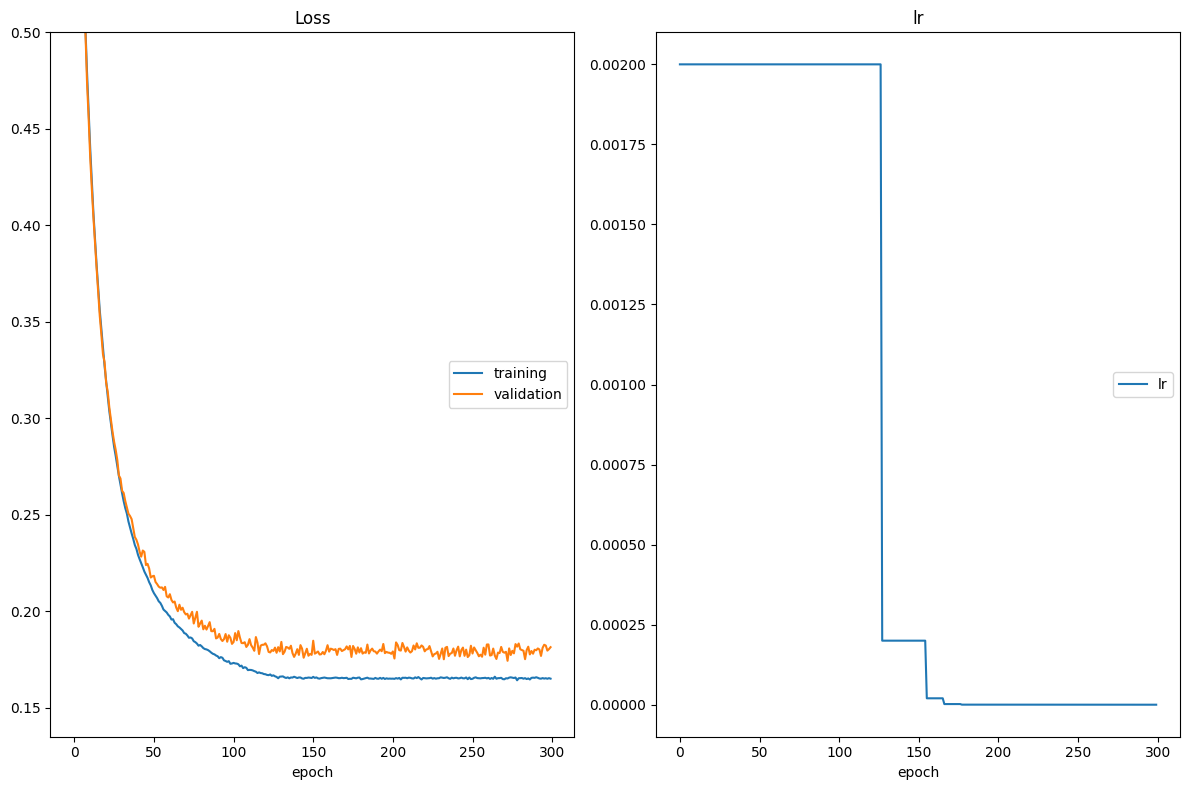

In [17]:
optimizer = get_optimizer(
    model,
    learning_rate=learning_rate,
    optimizer=opt,
    weight_decay=weight_decay,
)
loss = get_loss()

optimize(
    data_loaders,
    model,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/model_transfer.pt",
    interactive_tracking=True
)

## 5. Get Predictions

In [18]:
import torchvision.transforms as T
import torch.nn.functional as F

class Predictor(nn.Module):

    def __init__(self, model, class_names, mean, std):
        super().__init__()

        self.model = model.eval()
        self.class_names = class_names

        # We use nn.Sequential and not nn.Compose because the former
        # is compatible with torch.script, while the latter isn't
        self.transforms = nn.Sequential(
            T.Resize([256, ]),  # We use single int value inside a list due to torchscript type restrictions
            T.CenterCrop(224),
            T.ConvertImageDtype(torch.float),
            T.Normalize(mean.tolist(), std.tolist())
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            # 1. apply transforms
            x  = self.transforms(x)
            # 2. get the logits
            x  = self.model(x)
            # 3. apply softmax across dim=1
            x  = F.softmax(x, dim=1)

            return x

In [19]:
import torch

# Then let's move the model_transfer to the CPU
# (we don't need GPU for inference)
model = model.cpu()
# Let's make sure we use the right weights by loading the
# best weights we have found during training
# NOTE: remember to use map_location='cpu' so the weights
# are loaded on the CPU (and not the GPU)
model.load_state_dict(
    torch.load("checkpoints/model_transfer.pt", map_location="cpu")
)

# Let's wrap our model using the predictor class
image_folder = "images/test"
mean, std = compute_mean_and_std()
class_names = test_df.columns[2:]
predictor = Predictor(model, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor)
scripted_predictor.save("checkpoints/transfer_exported.pt")

In [20]:
def predictor_test(test_dataloader, test_dataset, model_reloaded):
    """
    Test the predictor. Since the predictor does not operate on the same tensors
    as the non-wrapped model, we need a specific test function (can't use one_epoch_test)
    """

    pred = []
    
    for x in tqdm(test_dataset, total=len(test_dataloader.dataset), leave=True, ncols=80):
        softmax = model_reloaded(x[0].unsqueeze(dim=0))
        pred.append(softmax[0])

    return pred

In [21]:
model_reloaded = torch.jit.load("checkpoints/transfer_exported.pt")

predictions = predictor_test(data_loaders['test'], test_dataset, model_reloaded)

100%|███████████████████████████████████████████| 86/86 [00:03<00:00, 27.57it/s]


In [22]:
# Convert each tensor to a numpy array
arrays = [pred.numpy() for pred in predictions]

# # Create the pandas DataFrame
new_df = pd.DataFrame(data=arrays, columns=df.columns[2:])

In [23]:
result = pd.concat([test_df,new_df], axis=1)

result.to_csv('test_result.csv')

In [24]:
result

,image_id,labels,people,trees,nature,bicycle,pavement,flowers,traffic signs,lamp posts,...,table,pencil,stroller,tents,stage,book,books,cars,flag,pole
0,img102.jpg,,0.104963,0.134284,0.004185,0.016023,0.003592,0.006763,0.005313,0.012985,...,0.004204,0.003914,0.002101,0.007444,0.004788,0.002548,0.009283,0.017912,0.001010,0.001968
1,img103.jpg,,0.104844,0.134440,0.004200,0.016026,0.003589,0.006759,0.005315,0.012975,...,0.004197,0.003907,0.002092,0.007457,0.004802,0.002545,0.009252,0.017841,0.001010,0.001971
2,img11.jpg,,0.104471,0.134322,0.004190,0.016060,0.003582,0.006769,0.005312,0.013064,...,0.004202,0.003911,0.002107,0.007484,0.004823,0.002566,0.009276,0.017770,0.001014,0.001967
3,img113.jpg,,0.104120,0.134463,0.004203,0.016077,0.003568,0.006781,0.005285,0.013135,...,0.004204,0.003926,0.002103,0.007480,0.004821,0.002578,0.009288,0.017801,0.001012,0.001966
4,img114.jpg,,0.104780,0.134317,0.004179,0.016051,0.003569,0.006826,0.005303,0.013079,...,0.004168,0.003921,0.002093,0.007471,0.004817,0.002576,0.009248,0.017873,0.001017,0.001966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,img81.jpg,,0.104891,0.135073,0.004210,0.015874,0.003576,0.006664,0.005325,0.013125,...,0.004184,0.003893,0.002077,0.007469,0.004789,0.002535,0.009234,0.017601,0.001003,0.001960
82,img84.jpg,,0.104497,0.135029,0.004181,0.016006,0.003576,0.006783,0.005321,0.013169,...,0.004192,0.003898,0.002087,0.007480,0.004818,0.002576,0.009255,0.017700,0.001009,0.001968
83,img90.jpg,,0.104867,0.134885,0.004175,0.015997,0.003566,0.006750,0.005309,0.013091,...,0.004185,0.003901,0.002098,0.007482,0.004807,0.002563,0.009229,0.017790,0.001011,0.001961
84,img93.jpg,,0.104903,0.134687,0.004211,0.015967,0.003608,0.006723,0.005313,0.013056,...,0.004214,0.003928,0.002104,0.007467,0.004775,0.002541,0.009274,0.017726,0.001011,0.001986


In [25]:
result.iloc[:,2:] = result.iloc[:,2:].rank() 

In [26]:
result

,image_id,labels,people,trees,nature,bicycle,pavement,flowers,traffic signs,lamp posts,...,table,pencil,stroller,tents,stage,book,books,cars,flag,pole
0,img102.jpg,,76.0,28.0,23.0,52.0,75.0,42.0,53.0,10.0,...,67.0,50.0,64.0,16.0,17.0,23.0,64.0,75.0,33.0,54.0
1,img103.jpg,,61.0,39.0,69.0,55.0,69.0,37.0,56.0,7.0,...,49.0,40.0,39.0,24.0,41.0,17.0,38.0,60.0,37.0,71.0
2,img11.jpg,,16.0,31.0,38.0,65.0,53.0,48.0,51.0,38.0,...,60.0,45.0,76.0,67.0,76.0,56.0,57.0,40.0,65.0,49.0
3,img113.jpg,,2.0,41.0,75.0,70.0,17.0,56.0,6.0,76.0,...,66.0,68.0,65.0,62.0,73.0,77.0,65.0,48.0,52.0,42.0
4,img114.jpg,,51.0,30.0,9.0,63.0,19.0,79.0,27.0,46.0,...,3.0,62.0,43.0,51.0,67.0,74.0,32.0,68.0,80.0,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,img81.jpg,,67.0,69.0,81.0,7.0,35.0,2.0,74.0,71.0,...,24.0,18.0,10.0,47.0,19.0,6.0,24.0,3.0,7.0,15.0
82,img84.jpg,,17.0,67.0,14.0,43.0,34.0,59.0,68.0,85.0,...,39.0,26.0,28.0,61.0,70.0,75.0,40.0,16.0,31.0,53.0
83,img90.jpg,,64.0,59.0,3.0,40.0,12.0,29.0,42.0,56.0,...,25.0,31.0,54.0,66.0,52.0,51.0,16.0,43.0,42.0,18.0
84,img93.jpg,,70.0,52.0,83.0,29.0,86.0,15.0,52.0,34.0,...,83.0,72.0,70.0,42.0,4.0,13.0,52.0,26.0,46.0,86.0


In [27]:
# result.to_csv('test_result.csv')

In [28]:
result.iloc[:,2:] = result.iloc[:,2:].applymap(lambda x: 1 if x > 80 else 0)

In [29]:
# Convert column names from feature name back to original labels for submission
label_arr = label.to_numpy()[:,::-1]
result = result.rename(columns=dict(label_arr))

In [30]:
# Define a lambda function to return the column names where the row value is 1
get_column_names = lambda row: list(result.columns[row == 1])

# Apply the lambda function to each row
result['labels'] = result.apply(get_column_names, axis=1)

In [31]:
result['labels'] = result['labels'].apply(lambda x: ' '.join(x))

In [32]:
result = result.iloc[:,:2]
result.to_csv('sample_submission.csv')